## Assignment 3 Pattern Mining and Recommender Systems: Individual Code

### Task 3: System integration and research

### ruhin, 1906313, Version 01

# 0. EDA


In [4]:
import pandas as pd

In [5]:
df = pd.read_csv("data/Groceries data train.csv")
df.head(5)

,User_id,Date,itemDescription,year,month,day,day_of_week
0,2351.0,1/01/2014,cleaner,2014.0,1.0,1.0,2.0
1,2226.0,1/01/2014,sausage,2014.0,1.0,1.0,2.0
2,1922.0,1/01/2014,tropical fruit,2014.0,1.0,1.0,2.0
3,2943.0,1/01/2014,whole milk,2014.0,1.0,1.0,2.0
4,1249.0,1/01/2014,citrus fruit,2014.0,1.0,1.0,2.0


In [6]:
df.isnull().sum()

User_id            7603
Date               7603
itemDescription    7603
year               7603
month              7603
day                7603
day_of_week        7603
dtype: int64

In [7]:
df.dropna(inplace=True)
df.isnull().sum()

User_id            0
Date               0
itemDescription    0
year               0
month              0
day                0
day_of_week        0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19382 entries, 0 to 19381
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   User_id          19382 non-null  float64
 1   Date             19382 non-null  object 
 2   itemDescription  19382 non-null  object 
 3   year             19382 non-null  float64
 4   month            19382 non-null  float64
 5   day              19382 non-null  float64
 6   day_of_week      19382 non-null  float64
dtypes: float64(5), object(2)
memory usage: 1.2+ MB


In [9]:
# convert User_id to int
df['User_id'] = df['User_id'].astype(int)

In [10]:
df.describe()

,User_id,year,month,day,day_of_week
count,19382.000000,19382.000000,19382.000000,19382.000000,19382.000000
mean,3009.050769,2014.057012,6.166134,15.391342,3.023785
std,1158.135945,0.231871,3.572992,8.750628,1.994446
min,1000.000000,2014.000000,1.000000,1.000000,0.000000
25%,1998.000000,2014.000000,3.000000,8.000000,1.000000
50%,3015.500000,2014.000000,6.000000,15.000000,3.000000
75%,4025.000000,2014.000000,9.000000,23.000000,5.000000
max,5000.000000,2015.000000,12.000000,31.000000,6.000000


## EDA

In [11]:
print(f"Recording period: {df['Date'].min()} to {df['Date'].max()}")
print(f"Total transactions: {len(df)}")
print(f"Unique users: {df['User_id'].nunique()}")
print(f"Unique items: {df['itemDescription'].nunique()}")

Recording period: 1/01/2014 to 9/12/2014
Total transactions: 19382
Unique users: 3493
Unique items: 167


### Item-based Analysis

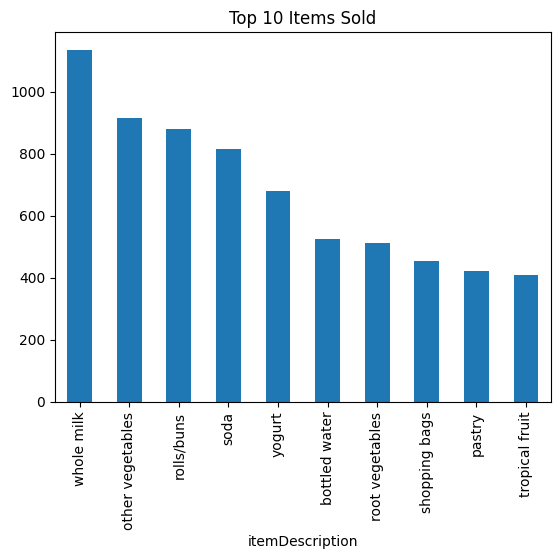

In [12]:
import matplotlib.pyplot as plt
#Plot the top items
top_items = df['itemDescription'].value_counts().head(10)
top_items.plot(kind='bar', title='Top 10 Items Sold')
plt.show()


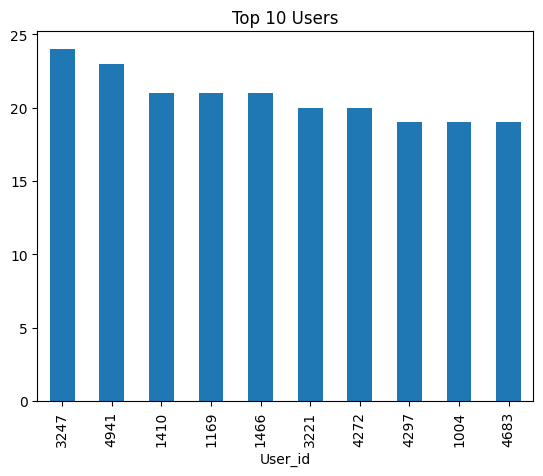

In [13]:
# plot top 10 users
top_users = df['User_id'].value_counts().head(10)
top_users.plot(kind='bar', title='Top 10 Users')
plt.show()



### Time-based analysis

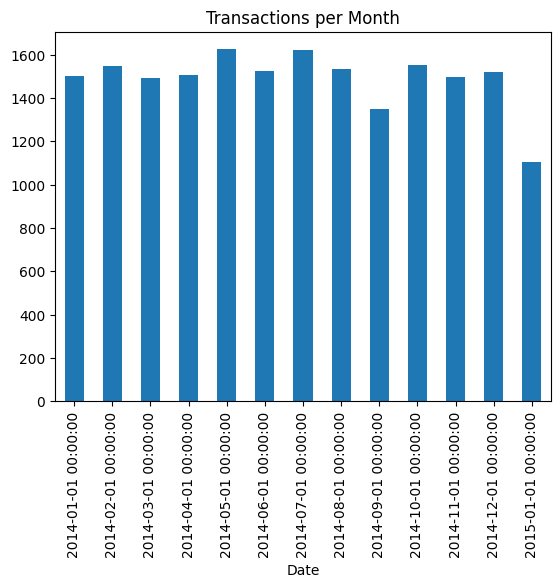

In [15]:
# Ensure the Date column is in datetime format
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Plot number of transactions per month
transactions_per_month = df.groupby(df['Date'].dt.to_period('M')).size()
transactions_per_month.index = transactions_per_month.index.to_timestamp()
transactions_per_month.plot(kind='bar', title='Transactions per Month')
plt.xticks(rotation=90)
plt.show()

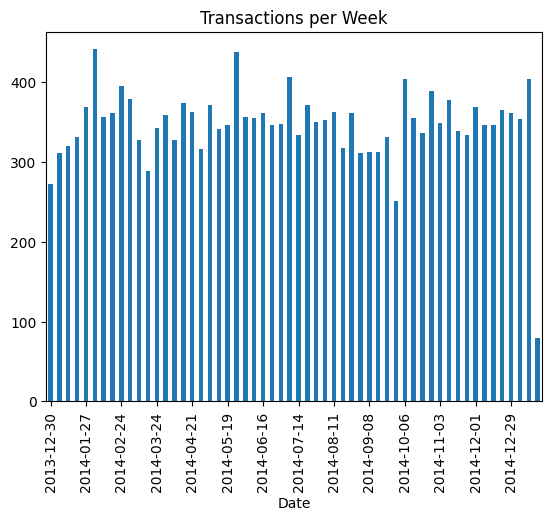

In [16]:
# Plot number of transactions per week
transactions_per_week = df.groupby(df['Date'].dt.to_period('W')).size()
transactions_per_week.index = transactions_per_week.index.to_timestamp()
transactions_per_week.plot(kind='bar', title='Transactions per Week')
plt.xticks(ticks=range(0, len(transactions_per_week), 4), labels=transactions_per_week.index[::4].strftime('%Y-%m-%d'), rotation=90)
plt.show()

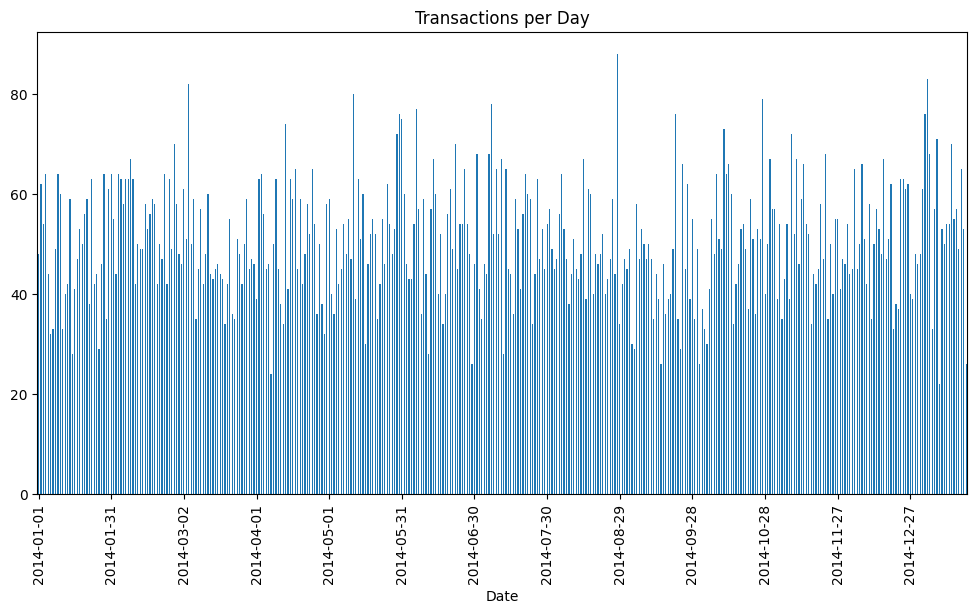

In [17]:
# Plot number of transactions per day
transactions_per_day = df.groupby(df['Date'].dt.to_period('D')).size()
transactions_per_day.plot(kind='bar', title='Transactions per Day', figsize=(12, 6))
plt.xticks(ticks=range(0, len(transactions_per_day), 30), labels=transactions_per_day.index[::30].strftime('%Y-%m-%d'), rotation=90)
plt.show()


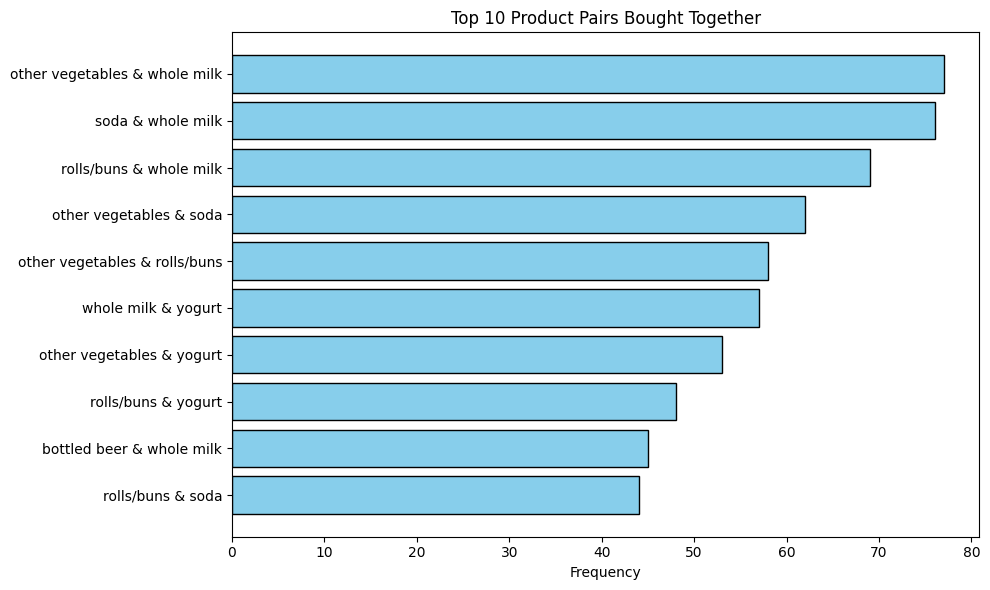

In [18]:
import pandas as pd
from itertools import combinations
from collections import Counter
import matplotlib.pyplot as plt

# Step 1: Group items by User and Date
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
grouped = df.groupby(['User_id', 'Date'])['itemDescription'].apply(list)

# Step 2: Generate item pairs from each transaction
pair_counter = Counter()
for items in grouped:
    if len(items) > 1:
        pairs = combinations(sorted(set(items)), 2)  # avoid duplicate pairs like ('a','b') and ('b','a')
        pair_counter.update(pairs)

# Step 3: Get most common pairs
top_pairs = pair_counter.most_common(10)

pairs, counts = zip(*top_pairs)
pair_labels = [' & '.join(pair) for pair in pairs]

plt.figure(figsize=(10, 6))
plt.barh(pair_labels, counts, color='skyblue', edgecolor='black')
plt.xlabel("Frequency")
plt.title("Top 10 Product Pairs Bought Together")
plt.gca().invert_yaxis()  # highest on top
plt.tight_layout()
plt.show()

### Recency analysis

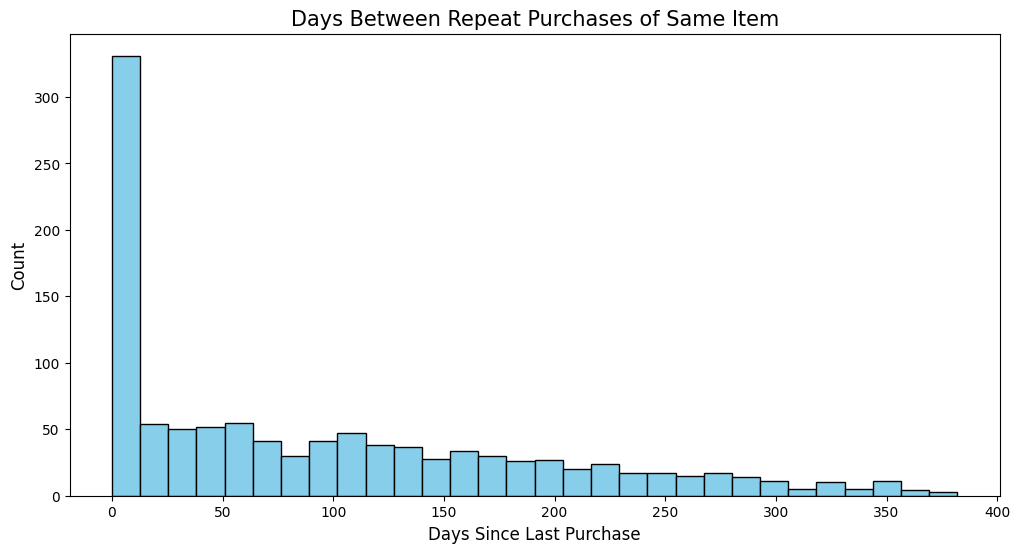

In [19]:
df_sorted = df.sort_values(['User_id', 'Date'])

# Calculate the max date in the dataset
max_date = df['Date'].max()

# Initialize lists to store recency data
user_ids = []
items = []
repeat_purchases = []
days_since_last = []

# Track the most recent purchase for each user-item pair
last_purchase = {}

# Iterate through the sorted dataframe
for _, row in df_sorted.iterrows():
    user = row['User_id']
    item = row['itemDescription']
    date = row['Date']
    
    # Check if this user-item pair has been seen before
    key = (user, item)
    if key in last_purchase:
        days = (date - last_purchase[key]).days
        user_ids.append(user)
        items.append(item)
        repeat_purchases.append(True)
        days_since_last.append(days)
    else:
        user_ids.append(user)
        items.append(item)
        repeat_purchases.append(False)
        days_since_last.append(None)
    
    # Update the last purchase date
    last_purchase[key] = date

# Create a dataframe with the recency data
recency_df = pd.DataFrame({
    'User_id': user_ids,
    'itemDescription': items,
    'is_repeat': repeat_purchases,
    'days_since_last': days_since_last
})

# Filter for repeat purchases
repeat_df = recency_df[recency_df['is_repeat']]

# Plot distribution of days between repeat purchases
plt.figure(figsize=(12, 6))
plt.hist(repeat_df['days_since_last'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title('Days Between Repeat Purchases of Same Item', fontsize=15)
plt.xlabel('Days Since Last Purchase', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

Most of people buy same set of products again and again. => the pattern should be predictable

### Integration with mock data


In [28]:
class PatternMining:
    def __init__(self, raw_df):
        self.raw_df = raw_df
        
    def recommend_mock(self):
        """
        Mock recommendation function.
        Returns a series of scored frequent patterns.
        """
        mock_output_task_1 = {
            'flower soil/fertilizer': [('other vegetables', 0.7)],
            'dishes': [('male cosmetics', 0.6)],
            'salty snack': [('root vegetables', 0.5)],
            'misc. beverages': [('brown bread', 0.4)],
            'salty': [('candles', 0.3)],
        }
        # Convert the dictionary to a pandas Series
        return mock_output_task_1

class CollaborativeFiltering:
    def __init__(self, df):
        self.df = df
    def recommend_mock(self):
        """
        Mock recommendation function.
        Returns a series of scored collaborative filtering recommendations.
        """
        mock_output_task_2 = {
            'sugar': [('milk', 0.7)],
            'flour': [('eggs', 0.6)],
            'ketchup': [('mayonnaise', 0.5)],
        }
        return mock_output_task_2
# Mock output for task 1

class RecommendationSystem:
    def __init__(self, pattern_mining: PatternMining, collaborative_filtering: CollaborativeFiltering):
        self.pattern_mining = pattern_mining
        self.collaborative_filtering = collaborative_filtering

    def recommend_mock(self, top_k, user_id=None):
        # Mock recommendation logic
        pattern_mining_recommendations = self.pattern_mining.recommend_mock()
        collaborative_filtering_recommendations = self.collaborative_filtering.recommend_mock()
        
        finally_recommendations = {}
        for item, recommendations in pattern_mining_recommendations.items():
            finally_recommendations[item] = recommendations[:top_k]
        for item, recommendations in collaborative_filtering_recommendations.items():
            if item not in finally_recommendations:
                finally_recommendations[item] = recommendations[:top_k]
        # Limit the number of recommendations to top_k
        return dict(list(finally_recommendations.items())[:top_k])
# Initialize the classes
pattern_mining = PatternMining(df)
collaborative_filtering = CollaborativeFiltering(df)
# Initialize the recommendation system
recommendation_system = RecommendationSystem(pattern_mining, collaborative_filtering)
# Get recommendations
recommendations = recommendation_system.recommend_mock(top_k=3)
# Print the recommendations 
for item, recs in recommendations.items():
    print(f"Item: {item}")
    for rec in recs:
        print(f"  Recommended: {rec[0]} with score {rec[1]}")

Item: flower soil/fertilizer
  Recommended: other vegetables with score 0.7
Item: dishes
  Recommended: male cosmetics with score 0.6
Item: salty snack
  Recommended: root vegetables with score 0.5


## Integration


### Task 1: Pattern mining

In [13]:
from pattern_recommender import PatternRecommender
import pandas as pd
import pickle

user_id=4942

with open("saved_rules.pkl", "rb") as f:
    saved_rules = pickle.load(f)

pattern_recommender = PatternRecommender('./data/Groceries data train.csv')
output = pattern_recommender.recommend(
    user_id=user_id,
    recent_days=None,
    min_support=0.0015,
    top_k=5,
    pre_mined_rules=saved_rules
)

print(" Mode:", output["mode"])
print(" Recommended Items:", output["recommended_items"])
print(" Reason:", output["reason"])
print(" Top Rules:")
print(output["top_rules"].to_string(index=False))

 Mode: user mode with rules
 Recommended Items: [('whole milk', 3.46285)]
 Reason: Rules matched and used
 Top Rules:
        antecedents  consequents  support  confidence     lift  combo_score  surprise_score  rec_value      NUS  user_rule_score
(frozen vegetables) (whole milk) 0.002751         0.1 0.766361     0.076636        0.094146   3.462854 0.211889         0.362827


### Task 2: Collaborative filtering

In [3]:
from collaborative_filtering import CFRecommender

cf_recommender = CFRecommender("data/Groceries data train.csv")
output = cf_recommender.recommend(user_id, is_mock=True)

output

[('dish cleaner', 1),
 ('turkey', 1),
 ('skin care', 1),
 ('hygiene articles', 1),
 ('rice', 1)]

### Task 3: System integration

In [13]:
from collaborative_filtering import CFRecommender
from pattern_recommender import PatternRecommender
import pandas as pd
import pickle

class RecommendationSystem:
    def __init__(self, data_path, pattern_recommender: PatternRecommender, cf_recommender: CFRecommender):
        self.pattern_recommender = pattern_recommender
        self.cf_recommender = cf_recommender
        self.data_path = data_path
        
        self.load_df()
        
        with open("saved_rules.pkl", "rb") as f:
            self.saved_rules = pickle.load(f)
            
        
    def load_df(self):
        df = pd.read_csv(self.data_path)
        df['user_id'] = df['user_id'].astype(str)
        self.df = df

    def handle_cold_start(self, top_n): # New user
        # Return most frequently bought items
        return self.df['item_description'].value_counts().index[:top_n].tolist()
        
    def recommend(self, user_id, is_use_patterns, top_k=5):
        if user_id not in self.df['user_id'].unique():
            print(f"New user: {user_id}. Recommending most frequently bought items.")
            return self.handle_cold_start(top_k)

        scored_recommendation = None
        if is_use_patterns:
            output = self.pattern_recommender.recommend(
                user_id=user_id,
                recent_days=344,
                min_support=0.0015,
                top_k=5,
                pre_mined_rules=self.saved_rules
            )
            
            scored_recommendation = output["recommended_items"]
            
        # collaborative filtering recommender
        return self.cf_recommender.recommend(user_id, scored_recommendation, top_k)
    
# Initialize the recommendation system
data_path = "data/train.csv"
pattern_recommender = PatternRecommender(data_path)
cf_recommender = CFRecommender(data_path)
recommendation_system = RecommendationSystem(data_path, pattern_recommender, cf_recommender)

# Get recommendations for a user
user_id = '1002'
is_use_patterns = True
recommendations = recommendation_system.recommend(user_id, is_use_patterns, top_k=10)
recommendations

Index(['whole milk', 'other vegetables', 'rolls/buns', 'soda', 'yogurt',
       'root vegetables', 'bottled water', 'tropical fruit', 'shopping bags',
       'pastry'],
      dtype='object', name='item_description')

## FINAL PRODUCT (just run this cell)

In [18]:
from collaborative_filtering import CFRecommender
from pattern_recommender import PatternRecommender
import pandas as pd
import pickle

class RecommendationSystem:
    def __init__(self, data_path, pattern_recommender: PatternRecommender, cf_recommender: CFRecommender):
        self.pattern_recommender = pattern_recommender
        self.cf_recommender = cf_recommender
        self.data_path = data_path
        
        self.load_df()
        
        with open("saved_rules.pkl", "rb") as f:
            self.saved_rules = pickle.load(f)
            
        
    def load_df(self):
        df = pd.read_csv(self.data_path)
        df['user_id'] = df['user_id'].astype(str)
        self.df = df

    def handle_cold_start(self, top_n): # New user
        # Return most frequently bought items
        return self.df['item_description'].value_counts().index[:top_n].tolist()
        
    def recommend(self, user_id, is_use_patterns, top_k=5):
        if user_id not in self.df['user_id'].unique():
            print(f"New user: {user_id}. Recommending most frequently bought items.")
            return self.handle_cold_start(top_k)

        scored_recommendation = None
        if is_use_patterns:
            output = self.pattern_recommender.recommend(
                user_id=user_id,
                recent_days=344,
                min_support=0.0015,
                top_k=5,
                pre_mined_rules=self.saved_rules
            )
            
            scored_recommendation = output["recommended_items"]
            
        # collaborative filtering recommender
        return self.cf_recommender.recommend(user_id, scored_recommendation, top_k)
    
# Initialize the recommendation system
data_path = "data/train.csv"
pattern_recommender = PatternRecommender(data_path)
cf_recommender = CFRecommender(data_path)
recommendation_system = RecommendationSystem(data_path, pattern_recommender, cf_recommender)

user_id = input("Enter User ID: ")
if not user_id.isdigit():
    raise ValueError("User ID must be an integer string.")

option = input("Use frequent patterns? (with/without): ").strip().lower()
is_use_patterns = option == "with"
print(f"Recommending for user {user_id}  {'using' if is_use_patterns else 'not using'} frequent patterns.")

recommendations = recommendation_system.recommend(user_id, is_use_patterns, top_k=10)
for idx, item in enumerate(recommendations):
    print(f"{idx + 1}. {item}")

Recommending for user 4524  using frequent patterns.
1. whole milk
2. other vegetables
3. rolls/buns
4. soda
5. yogurt
6. root vegetables
7. bottled water
8. tropical fruit
9. shopping bags
10. pastry


## Evaluate 

In [13]:
import pandas as pd

validation_size = 0.2
train_val_df = pd.read_csv("data/Groceries data train.csv")

train_val_df = train_val_df.dropna()

train_val_df = train_val_df[['User_id', 'itemDescription', 'Date']]

train_val_df['User_id'] = train_val_df['User_id'].astype('int')
train_val_df['Date'] = pd.to_datetime(train_val_df['Date'], dayfirst=True)

# Split training data into train and validation sets
# Group by user to ensure each user has items in train and validation
user_groups = train_val_df.groupby('User_id')

train_data = []
validation_data = []

for user_id, group in user_groups:
    # Sort by date for time-based evaluation
    group = group.sort_values(by=['Date'])
    
    # Calculate split point
    n_samples = len(group)
    n_validation = max(1, int(validation_size * n_samples))
    
    # Split based on time
    user_train = group.iloc[:(n_samples - n_validation)]
    user_validation = group.iloc[(n_samples - n_validation):]
    
    train_data.append(user_train)
    validation_data.append(user_validation)

train_df = pd.concat(train_data)
validation_df = pd.concat(validation_data)

# Rename columns
train_df = train_df.rename(columns={
    'User_id': 'user_id',
    'itemDescription': 'item_description',
    'Date': 'date'
})

validation_df = validation_df.rename(columns={
    'User_id': 'user_id',
    'itemDescription': 'item_description',
    'Date': 'date'
})

print(f"Train set: {len(train_df)} entries")
print(f"Validation set: {len(validation_df)} entries")

Train set: 15408 entries
Validation set: 3974 entries


In [14]:
train_df.to_csv("data/train.csv", index=False)
validation_df.to_csv("data/validation.csv", index=False)

In [4]:
from collaborative_filtering import CFRecommender
from pattern_recommender import PatternRecommender
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt

class RecommendationSystem:
    def __init__(self, data_path, pattern_recommender: PatternRecommender, cf_recommender: CFRecommender):
        self.pattern_recommender = pattern_recommender
        self.cf_recommender = cf_recommender
        
        self.df = self.load_df(data_path)
        
        with open("saved_rules.pkl", "rb") as f:
            self.saved_rules = pickle.load(f)
            
        
    def load_df(self, data_path):
        return pd.read_csv(data_path)

    def handle_cold_start(self, top_n): # New user
        # Return most frequently bought items
        return self.df['item_description'].value_counts().index[:top_n].tolist()
        
    def recommend(self, user_id, is_recency, is_use_patterns, top_k=5):
        if user_id not in self.df['user_id'].unique():
            return self.handle_cold_start(top_k)

        recent_days = 344 if is_recency else None
        
        scored_recommendation = None
        if is_use_patterns:
            output = self.pattern_recommender.recommend(
                user_id=user_id,
                recent_days=recent_days,
                min_support=0.0015,
                top_k=5,
                pre_mined_rules=self.saved_rules
            )
            
            scored_recommendation = output["recommended_items"]
            
        # collaborative filtering recommender
        recommendations = self.cf_recommender.recommend(user_id, scored_recommendation, top_k)
        return [i[0] for i in recommendations]

In [5]:
def precision_at_k(recommended, relevant, k):
    recommended = recommended[:k]
    return len(set(recommended) & set(relevant)) / k

def hit_at_k(recommended, relevant, k):
    return int(any(item in relevant for item in recommended[:k]))

def average_precision_at_k(recommended, relevant, k):
    score = 0.0
    hits = 0
    for i, item in enumerate(recommended[:k]):
        if item in relevant:
            hits += 1
            score += hits / (i + 1)
    return score / min(len(relevant), k) if relevant else 0

def reciprocal_rank(recommended, relevant):
    for i, item in enumerate(recommended):
        if item in relevant:
            return 1 / (i + 1)
    return 0

In [3]:
# Initialize the recommendation system
train_path = "data/train.csv"
val_path = "data/validation.csv"

pattern_recommender = PatternRecommender(train_path)
cf_recommender = CFRecommender(train_path)
recommendation_system = RecommendationSystem(train_path, pattern_recommender, cf_recommender)


validation_df = pd.read_csv("data/validation.csv")

results = {
    "with_recency_with_patterns": [],
    "with_recency_no_patterns": [],
    "no_recency_with_patterns": [],
    "no_recency_no_patterns": []
}

for _, row in tqdm(validation_df.iterrows(), total=len(validation_df)):
    user_id = row['user_id']
    true_item = row['item_description']
    relevant = [true_item]
    
    configs = [
        ("with_recency_with_patterns", True, True),
        ("with_recency_no_patterns", True, False),
        ("no_recency_with_patterns", False, True),
        ("no_recency_no_patterns", False, False),
    ]

    for key, recency, pattern in configs:
        recs = recommendation_system.recommend(user_id, is_recency=recency, is_use_patterns=pattern, top_k=10)

        results[key].append({
            "precision@10": precision_at_k(recs, relevant, 10),
            "hit@10": hit_at_k(recs, relevant, 10),
            "ap@10": average_precision_at_k(recs, relevant, 10),
            "rr": reciprocal_rank(recs, relevant)
        })


100%|██████████| 3974/3974 [09:53<00:00,  6.70it/s]


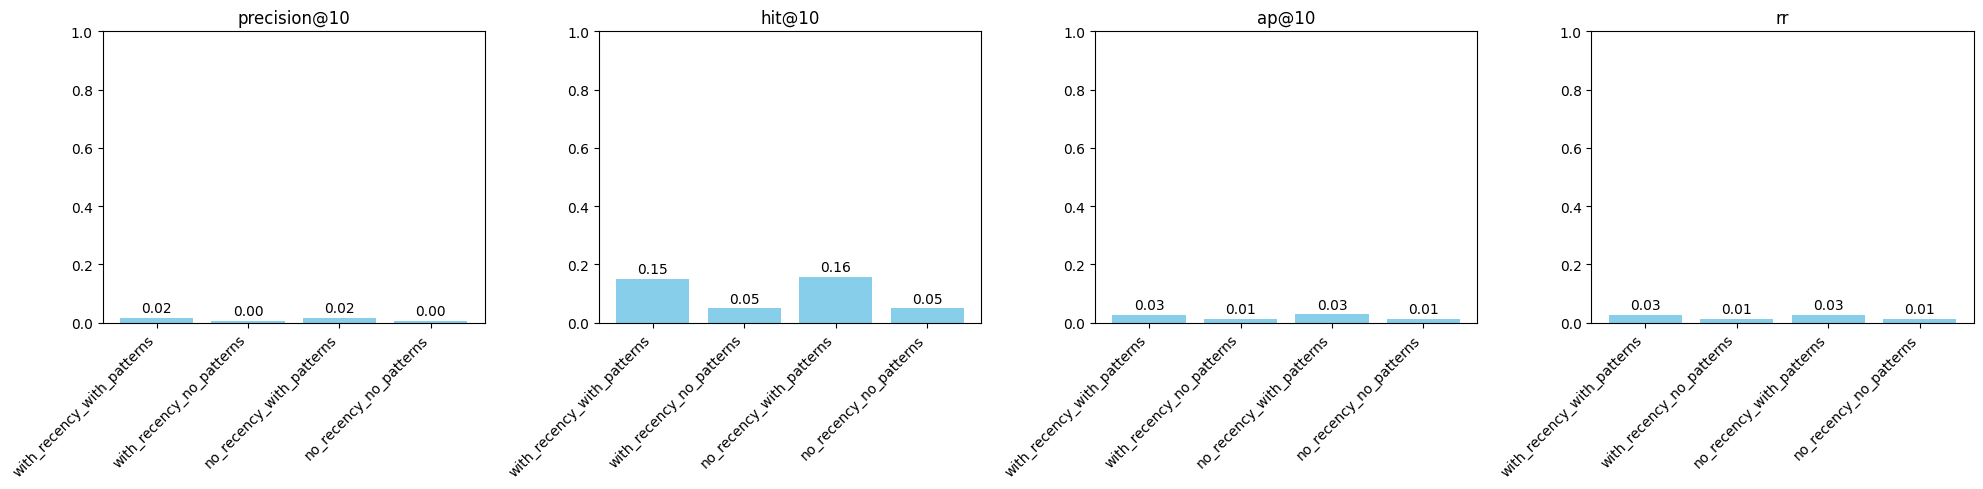

In [5]:
import json 

# Save the results to a JSON file
with open("results.json", "w") as f:
    json.dump(results, f, indent=4)

def plot_results(results):

    metric_names = ["precision@10", "hit@10", "ap@10", "rr"]
    config_labels = list(results.keys())

    averages = {
        metric: [np.mean([r[metric] for r in results[config]]) for config in config_labels]
        for metric in metric_names
    }

    fig, axs = plt.subplots(1, len(metric_names), figsize=(20, 5))
    
    for i, metric in enumerate(metric_names):
        axs[i].bar(config_labels, averages[metric], color='skyblue')
        axs[i].set_title(metric)
        axs[i].set_ylim(0, 1)
        axs[i].set_xticklabels(config_labels, rotation=45, ha='right')
        
        # Add values on top of each bar
        for j, value in enumerate(averages[metric]):
            axs[i].text(j, value + 0.02, f"{value:.2f}", ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()

plot_results(results)

# Final result

In [3]:
import pandas as pd

test_df = pd.read_csv("data/Groceries data test.csv")

test_df = test_df.dropna()

test_df = test_df[['user_id', 'itemDescription', 'Date']]

test_df['user_id'] = test_df['user_id'].astype('int')
test_df['Date'] = pd.to_datetime(test_df['Date'], dayfirst=True)

test_df = test_df.rename(columns={
    'itemDescription': 'item_description',
    'Date': 'date'
})

test_df.to_csv("data/test.csv", index=False)

In [6]:
# Initialize the recommendation system
train_path = "data/train.csv"
test_path = "data/test.csv"

pattern_recommender = PatternRecommender(train_path)
cf_recommender = CFRecommender(train_path)
recommendation_system = RecommendationSystem(train_path, pattern_recommender, cf_recommender)


test_df = pd.read_csv(test_path)

results = []

for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    user_id = row['user_id']
    true_item = row['item_description']
    relevant = [true_item]
    
    recs = recommendation_system.recommend(user_id, is_recency=False, is_use_patterns=True, top_k=10)

    results.append({
        "precision@10": precision_at_k(recs, relevant, 10),
        "hit@10": hit_at_k(recs, relevant, 10),
        "ap@10": average_precision_at_k(recs, relevant, 10),
        "rr": reciprocal_rank(recs, relevant)
    })


100%|██████████| 19383/19383 [08:28<00:00, 38.11it/s]


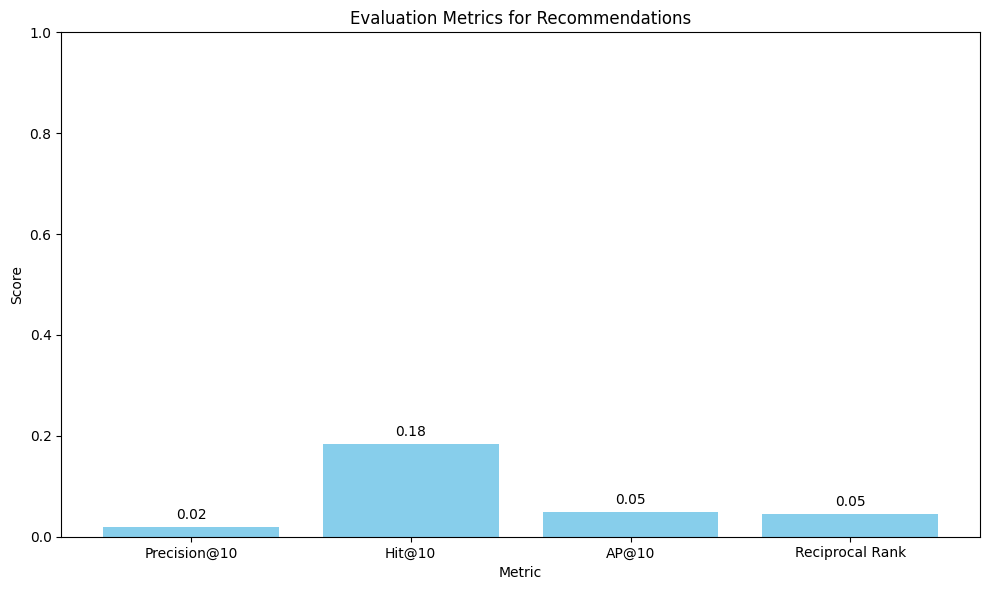

In [11]:
# Extract metrics
precision = [r['precision@10'] for r in results]
hit = [r['hit@10'] for r in results]
ap = [r['ap@10'] for r in results]
rr = [r['rr'] for r in results]

# Calculate averages
average_results = {
    "Precision@10": sum(precision) / len(precision),
    "Hit@10": sum(hit) / len(hit),
    "AP@10": sum(ap) / len(ap),
    "Reciprocal Rank": sum(rr) / len(rr)
}

# Plot the metrics
metrics = list(average_results.keys())
scores = list(average_results.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, scores, color='skyblue')
plt.ylim(0, 1.0)
plt.title("Evaluation Metrics for Recommendations")
plt.ylabel("Score")
plt.xlabel("Metric")

# Annotate each bar
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()